# The Option-Critic Architecture

Simple implementation of the [Option-Critic Architecture](https://arxiv.org/abs/1609.05140) on the Four-rooms environment.

### 1 Import Libraries and Modules

In [ ]:
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 4.1.4 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.1.0 which is incompatible.
jaxlib 0.3.15+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
jax 0.3.17 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
aeppl 0.0.33 requires scipy>=1.4.0, but you have scipy 1.1.0 which is incompatible.


In [ ]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import numpy as np

import scipy
import scipy.misc as misc
import scipy.special as special


class EpsGreedyPolicy():

	def __init__(self, rng, nstates, noptions, epsilon):
		self.rng = rng
		self.nstates = nstates
		self.noptions = noptions
		self.epsilon = epsilon
		self.Q_Omega_table = np.zeros((nstates, noptions))

	def Q_Omega(self, state, option=None):
		# return Q_Omega table (s, option)
		if option is None:
			return self.Q_Omega_table[state,:]
		else:
			return self.Q_Omega_table[state, option]

	def sample(self, state):
		if self.rng.uniform() < self.epsilon:
			# return random option
			return int(self.rng.randint(self.noptions))
		else:
			# return argmax Q_Omega(s)
			return int(np.argmax(self.Q_Omega(state)))


class SoftmaxPolicy():

	def __init__(self, rng, lr, nstates, nactions, temperature=1.0):
		self.rng = rng
		self.lr = lr
		self.nstates = nstates
		self.nactions = nactions
		self.temperature = temperature
		self.weights = np.zeros((nstates, nactions))

	def Q_U(self, state, action=None):
		if action is None:
			return self.weights[state,:]
		else:
			return self.weights[state, action]

	def pmf(self, state):
		exponent = self.Q_U(state) / self.temperature
		return np.exp(exponent - misc.logsumexp(exponent))

	def sample(self, state):
		return int(self.rng.choice(self.nactions, p=self.pmf(state)))

	def gradient(self):
		pass

	def update(self, state, action, Q_U):
		actions_pmf = self.pmf(state)
		self.weights[state, :] -= self.lr * actions_pmf * Q_U
		self.weights[state, action] += self.lr * Q_U


class SigmoidTermination():

	def __init__(self, rng, lr, nstates):
		self.rng = rng
		self.lr = lr
		self.nstates = nstates
		self.weights = np.zeros((nstates,))

	def pmf(self, state):
		return special.expit(self.weights[state])

	def sample(self, state):
		return int(self.rng.uniform() < self.pmf(state))

	def gradient(self, state):
		return self.pmf(state) * (1.0 - self.pmf(state)), state

	def update(self, state, advantage):
		magnitude, direction = self.gradient(state)
		self.weights[direction] -= self.lr * magnitude * advantage


class Critic():

	def __init__(self, lr, discount, Q_Omega_table, nstates, noptions, nactions):
		self.lr = lr
		self.discount = discount
		self.Q_Omega_table = Q_Omega_table
		self.Q_U_table = np.zeros((nstates, noptions, nactions))

	def cache(self, state, option, action):
		self.last_state = state
		self.last_option = option
		self.last_action = action
		self.last_Q_Omega = self.Q_Omega(state, option)

	def Q_Omega(self, state, option=None):
		if option is None:
			return self.Q_Omega_table[state, :]
		else:
			return self.Q_Omega_table[state, option]

	def Q_U(self, state, option, action):
		return self.Q_U_table[state, option, action]

	def A_Omega(self, state, option=None, eps=0):
		advantage = self.Q_Omega(state) - np.max(self.Q_Omega(state)) + eps

		if option is None:
			return advantage
		else:
			return advantage[option]

	def update_Qs(self, state, option, action, reward, done, terminations):
		# One step target for Q_Omega
		target = reward
		if not done:
			beta_omega = terminations[self.last_option].pmf(state)
			target += self.discount * ((1.0 - beta_omega)*self.Q_Omega(state, self.last_option) + \
						beta_omega*np.max(self.Q_Omega(state)))

		# Difference update
		tderror_Q_Omega = target - self.last_Q_Omega
		self.Q_Omega_table[self.last_state, self.last_option] += self.lr * tderror_Q_Omega

		tderror_Q_U = target - self.Q_U(self.last_state, self.last_option, self.last_action)
		self.Q_U_table[self.last_state, self.last_option, self.last_action] += self.lr * tderror_Q_U

		# Cache
		self.last_state = state
		self.last_option = option
		self.last_action = action
		if not done:
			self.last_Q_Omega = self.Q_Omega(state, option)

## env

In [ ]:
import numpy as np

class Banana:

  def __init__(self):
    layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""

    self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])

    # Four possible actions
    # 0: UP
    # 1: DOWN
    # 2: LEFT
    # 3: RIGHT
    self.action_space = np.array([0, 1, 2, 3])
    self.observation_space = np.zeros(np.sum(self.occupancy == 0))
    self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

    # Random number generator
    self.rng = np.random.RandomState(1234)

    self.tostate = {}
    statenum = 0
    for i in range(13):
      for j in range(13):
        if self.occupancy[i,j] == 0:
          self.tostate[(i,j)] = statenum
          statenum += 1
    self.tocell = {v:k for k, v in self.tostate.items()}

    
    self.banana = 0
    self.goal = 62
    self.init_states = list(range(self.observation_space.shape[0]))
    self.init_states.remove(self.banana)
    

  def render(self, show_banana=True, show_goal=True):
    current_grid = np.array(self.occupancy)
    current_grid[self.current_cell[0], self.current_cell[1]] = -1
    if show_banana:
      banana_cell = self.tocell[self.banana]
      current_grid[banana_cell[0], banana_cell[1]] = -1
    if show_goal:
      goal_cell = self.tocell[self.goal]
      current_grid[goal_cell[0], goal_cell[1]] = -1
    return current_grid

  def reset(self):
    state = 45
    self.current_cell = self.tocell[state]
    return state

  def check_available_cells(self, cell):
    available_cells = []
    for action in range(len(self.action_space)):
      next_cell = tuple(cell + self.directions[action])

      if not self.occupancy[next_cell]:
        available_cells.append(next_cell)
    return available_cells

  def step(self, action):
    """
    Takes a step in the environment with 2/3 probability and random action with 1/3 prob
    """
    next_cell = tuple(self.current_cell + self.directions[action])

    if not self.occupancy[next_cell]:
      if self.rng.uniform() < 1/3:
        available_cells = self.check_available_cells(self.current_cell)
        self.current_cell = available_cells[self.rng.randint(len(available_cells))]
      else:
        self.current_cell = next_cell
    state = self.tostate[self.current_cell]

    done = False
    reward = 0
    if state == self.banana:
      done = True
      reward = 10
    if state == self.goal:
      done = True
      reward = 100

    
    return state, reward, done, None


In [ ]:
class Map(object):
    def __init__(self, size):
        self.map_size = size
        self.occupancy = np.zeros((self.map_size, self.map_size))
        for i in range(self.map_size):
            self.occupancy[0][i] = 1
            self.occupancy[self.map_size - 1][i] = 1
            self.occupancy[i][0] = 1
            self.occupancy[i][self.map_size - 1] = 1
        for i in range(self.map_size):
            self.occupancy[i][int(self.map_size/2)] = 1
        for i in range(int(self.map_size/2)):
            self.occupancy[int(self.map_size/2)][i] = 1
        for i in range(int(self.map_size/2), self.map_size):
            self.occupancy[int(self.map_size/2)+1][i] = 1

        self.occupancy[6][2] = 0
        self.occupancy[3][6] = 0
        self.occupancy[7][9] = 0
        self.occupancy[10][6] = 0
        
        self.agt1_pos = [5, 5]
        self.banana = [1, 1]
        self.goal_pos = [7, 9]


    def reset(self):
        self.occupancy = np.zeros((self.map_size, self.map_size))
        for i in range(self.map_size):
            self.occupancy[0][i] = 1
            self.occupancy[self.map_size - 1][i] = 1
            self.occupancy[i][0] = 1
            self.occupancy[i][self.map_size - 1] = 1
        for i in range(self.map_size):
            self.occupancy[i][int(self.map_size/2)] = 1
        for i in range(int(self.map_size/2)):
            self.occupancy[int(self.map_size/2)][i] = 1
        for i in range(int(self.map_size/2), self.map_size):
            self.occupancy[int(self.map_size/2)+1][i] = 1

        self.occupancy[6][2] = 0
        self.occupancy[3][6] = 0
        self.occupancy[7][9] = 0
        self.occupancy[10][6] = 0
        self.agt1_pos = [5, 5]
        self.banana = [1, 1]
        self.goal_pos = [7, 9]


    def get_state(self):
        state = np.zeros(2)
        state[0] = self.agt1_pos[0] #/ self.map_size
        state[1] = self.agt1_pos[1] #/ self.map_size
        return state

    def get_next_state(self, action):
        # agent move
        if action == 0:  # move up
            if self.occupancy[self.agt1_pos[0] - 1][self.agt1_pos[1]] != 1:  # if can move
                self.agt1_pos[0] = self.agt1_pos[0] - 1
        elif action == 1:  # move down
            if self.occupancy[self.agt1_pos[0] + 1][self.agt1_pos[1]] != 1:  # if can move
                self.agt1_pos[0] = self.agt1_pos[0] + 1
        elif action == 2:  # move left
            if self.occupancy[self.agt1_pos[0]][self.agt1_pos[1] - 1] != 1:  # if can move
                self.agt1_pos[1] = self.agt1_pos[1] - 1
        elif action == 3:  # move right
            if self.occupancy[self.agt1_pos[0]][self.agt1_pos[1] + 1] != 1:  # if can move
                self.agt1_pos[1] = self.agt1_pos[1] + 1


        return self.get_state()

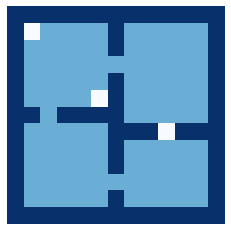

In [ ]:
env = Banana()
env.reset()

clear_output(True)
plt.imshow(env.render(show_banana=True), cmap='Blues')
plt.axis('off')
plt.show()

In [ ]:
env.observation_space.shape

(104,)

## option critic

### in reward

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random

class FeatureEncoder(nn.Module):
  def __init__(self, obs_dim, output_dim):
    super(FeatureEncoder, self).__init__()
    self.fc1 = nn.Linear(obs_dim, 32)
    self.fc2 = nn.Linear(32, 32)
    self.fc3 = nn.Linear(32, output_dim)
  
  def forward(self, x):
    x = torch.sigmoid(self.fc1(x.float()))
    x = torch.sigmoid(self.fc2(x))
    x = self.fc3(x)
    return x

class PredictNet_1(nn.Module):
  def __init__(self, action_dim, obs_feature_dim, output_dim):
    super(PredictNet_1, self).__init__()
    self.fc1 = nn.Linear(action_dim+obs_feature_dim, 32)
    self.fc2 = nn.Linear(32, 32)
    self.fc3 = nn.Linear(32, output_dim)
  
  def forward(self, action, obs_feature):
    x = torch.cat([action, obs_feature], dim=0)
    x = torch.sigmoid(self.fc1(x.float()))
    x = torch.sigmoid(self.fc2(x))
    x = self.fc3(x)
    return x

class PredictNet_2(nn.Module):
  def __init__(self, obs_feature_dim, action_dim):
    super(PredictNet_2, self).__init__()
    self.fc1 = nn.Linear(2*obs_feature_dim, 32)
    self.fc2 = nn.Linear(32, 32)
    self.fc3 = nn.Linear(32, action_dim)
  
  def forward(self, x1, x2):
    x = torch.cat([x1, x2], dim=0)
    x = torch.sigmoid(self.fc1(x.float()))
    x = torch.sigmoid(self.fc2(x))
    action_score = self.fc3(x)
    return F.softmax(action_score, dim=-1)


class ICM():
    def __init__(self, obs_dim=2, action_dim=4, obs_feature_dim=4, output_dim=4):
      super(ICM, self).__init__()
      self.obs_dim = obs_dim
      self.action_dim = action_dim
      self.obs_feature_dim = obs_feature_dim
      self.output_dim = output_dim

      self.feature_encoder = FeatureEncoder(obs_dim, obs_feature_dim)
      self.predict_net_1 = PredictNet_1(action_dim, obs_feature_dim, output_dim)
      self.predict_net_2 = PredictNet_2(obs_feature_dim, action_dim)

      self.optimizer1 = torch.optim.Adam(self.predict_net_1.parameters(), lr=1e-3)
      self.optimizer2 = torch.optim.Adam(self.predict_net_2.parameters(), lr=1e-3)

      self.crition = torch.nn.CrossEntropyLoss()

    def get_intrinsic_reward(self, action, state, next_state):
      action = torch.from_numpy(action)
      state_feature = self.feature_encoder(torch.from_numpy(state))
      
      next_state_feature = self.feature_encoder(torch.from_numpy(next_state))

      next_state_feature_pred = self.predict_net_1.forward(action, state_feature)
      intrinsic_reward = torch.norm(next_state_feature - next_state_feature_pred).item()

      action_pred = self.predict_net_2.forward(state_feature, next_state_feature)
      importance = torch.exp( -torch.norm(action - action_pred) ).item()

      # Train network 1
      #print("next state ", next_state_feature)
      #print("next state pred ", next_state_feature_pred)
      loss1 = torch.norm(next_state_feature - next_state_feature_pred)
      self.optimizer1.zero_grad()
      loss1.backward()
      self.optimizer1.step()

      # Train network 2
      """print("action ", action)
      print("action pred ", action_pred)
      loss2 = self.crition(action_pred, torch.tensor([0, 1, 0, 0])) #torch.norm(action - action_pred)
      
      loss2.backward()
      self.optimizer2.step()
      self.optimizer2.zero_grad()"""

      #intrinsic_reward = intrinsic_reward*importance
      return intrinsic_reward



### Train

Setting the hyperparameters.

In [ ]:
# Discount
discount = 0.99

# Learning rates - termination, intra-option, critic
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5

# Epsilon for epsilon-greedy for policy over options
epsilon = 0.1

# Temperature for softmax
temperature = 1e-2

# Number of runs
nruns = 10

# Number of episodes per run
nepisodes = 4000

# Maximum number of steps per episode
nsteps = 1000

# Number of options
noptions = 4

episode_explore = 500

In [ ]:
# Random number generator for reproducability
rng = np.random.RandomState(1234)

# The possible next goals (all in the lower right room)
possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

In [ ]:
map_maze = Map(13)

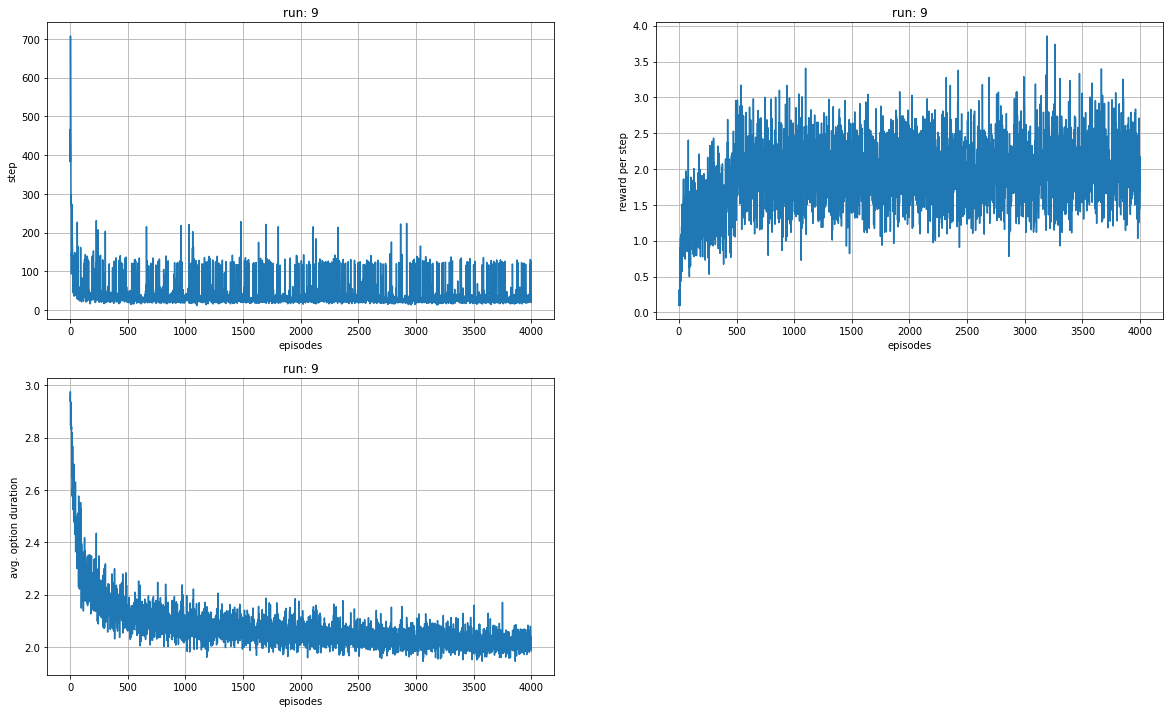

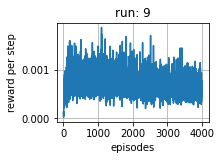

In [ ]:
import math

# History of steps and average durations
history = np.zeros((nruns, nepisodes, 4))

option_terminations_list = []

for run in range(nruns):


    env = Banana()
    map_maze = Map(13)

    
    nstates = env.observation_space.shape[0]
    nactions = env.action_space.shape[0]
    
    # Following three belong to the Actor
    
    # 1. The intra-option policies - linear softmax functions
    option_policies = [SoftmaxPolicy(rng, lr_intra, nstates, nactions, temperature) for _ in range(noptions)]
    
    # 2. The termination function - linear sigmoid function
    option_terminations = [SigmoidTermination(rng, lr_term, nstates) for _ in range(noptions)]
    
    # 3. The epsilon-greedy policy over options
    policy_over_options = EpsGreedyPolicy(rng, nstates, noptions, epsilon)
    
    # Critic
    critic = Critic(lr_critic, discount, policy_over_options.Q_Omega_table, nstates, noptions, nactions)

    icm = ICM(obs_dim=2, action_dim=4, obs_feature_dim=4, output_dim=4)
    
    
    for episode in range(nepisodes):
        
        state = env.reset()
        map_maze.reset()
        
        option = policy_over_options.sample(state)
        action = option_policies[option].sample(state)
        
        critic.cache(state, option, action)
        
        duration = 1
        option_switches = 0
        avg_duration = 0.0

        reward_acc = 0
        in_reward_acc = 0
        
        for step in range(1,nsteps):
            
            state, reward, done, _ = env.step(action)
            

            reward_acc += reward
            
            # Termination might occur upon entering new state
            if option_terminations[option].sample(state):
                option = policy_over_options.sample(state)
                option_switches += 1
                avg_duration += (1.0/option_switches)*(duration - avg_duration)
                duration = 1

            
            action = option_policies[option].sample(state)
            
            state_encoder = map_maze.get_state()
            next_state_encoder = map_maze.get_next_state(action)
            action_encoder = np.zeros(nactions)
            action_encoder[int(action)] = 1.0
            initrinstic_reward = icm.get_intrinsic_reward(action_encoder, state_encoder, next_state_encoder)
            in_reward_acc += initrinstic_reward

            
            
            
            # Critic update
            critic.update_Qs(state, option, action, reward + 1*initrinstic_reward/math.sqrt(episode+1), done, option_terminations)
            
            # Intra-option policy update with baseline
            Q_U = critic.Q_U(state, option, action)
            Q_U = Q_U - critic.Q_Omega(state, option)
            option_policies[option].update(state, action, Q_U)
            
            if episode < 1000:
              # Termination condition update
              option_terminations[option].update(state, critic.A_Omega(state, option, 0.0))
            else:
              option_terminations[option].update(state, critic.A_Omega(state, option, 0.0))
            
            duration += 1
            
            
            if done:   
              break
       
                
        history[run, episode, 0] = step
        history[run, episode, 1] = reward_acc/step
        history[run, episode, 2] = avg_duration
        history[run, episode, 3] = initrinstic_reward/step
   
        
    option_terminations_list.append(option_terminations)
    
    
    # Plot stuff
    clear_output(True)
    plt.figure(figsize=(20,12))
    plt.subplot(221)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('step')
    plt.plot(np.mean(history[:run+1,:,0], axis=0))
    plt.grid(True)

    plt.subplot(222)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('reward per step')
    plt.plot(np.mean(history[:run+1,:,1], axis=0))
    plt.grid(True)

    plt.subplot(223)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('avg. option duration')
    plt.plot(np.mean(history[:run+1,:,2], axis=0))
    plt.grid(True)
    

    plt.subplot(224)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('reward per step')
    plt.plot(np.mean(history[:run+1,:,3], axis=0))
    plt.grid(True)
    plt.show()

Run: 9


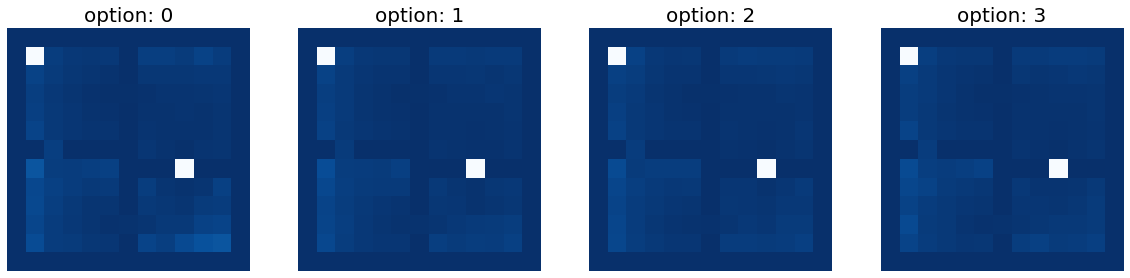

In [ ]:
for run in range(nruns):
    
    termination_maps = [env.occupancy.astype('float64') for _ in range(noptions)]
    
    for option in range(noptions):
        state = 0
        for i in range(13):
            for j in range(13):
                if termination_maps[option][i,j] == 0:
                    termination_maps[option][i,j] = option_terminations_list[run][option].pmf(state)
                    state += 1

    clear_output(True)
    print('Run: {}'.format(run))
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('option: 0', fontsize=20)
    plt.imshow(termination_maps[0], cmap='Blues')
    plt.axis('off')
    plt.subplot(142)
    plt.title('option: 1', fontsize=20)
    plt.imshow(termination_maps[1], cmap='Blues')
    plt.axis('off')
    plt.subplot(143)
    plt.title('option: 2', fontsize=20)
    plt.imshow(termination_maps[2], cmap='Blues')
    plt.axis('off')
    plt.subplot(144)
    plt.title('option: 3', fontsize=20)
    plt.imshow(termination_maps[3], cmap='Blues')
    plt.axis('off')
    plt.show()
    sleep(2)

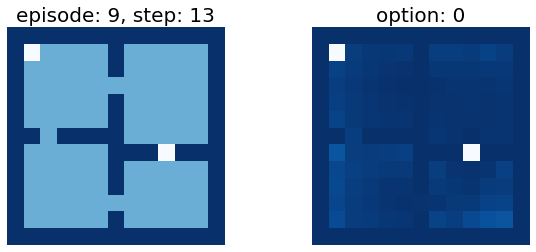

Goal reached!


In [ ]:
# Turn off exploration while testing
policy_over_options.epsilon = 0
for option in range(noptions):
    option_policies[option].temperature = 1e-10

env = Banana()

nepisodes = 10

rng = np.random.RandomState(1234)

for episode in range(nepisodes):

    state = env.reset()

    option = policy_over_options.sample(state)

    for step in range(nsteps):
        
        action = option_policies[option].sample(state)
        
        state, reward, done, _ = env.step(action)

        # Termination might occur upon entering new state
        if option_terminations[option].sample(state):
            option = policy_over_options.sample(state)
        
        clear_output(True)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('episode: {}, step: {}'.format(episode, step), fontsize=20)
        plt.imshow(env.render(), cmap='Blues', )
        plt.axis('off')
        plt.subplot(122)
        plt.title('option: %s' %option, fontsize=20)
        plt.imshow(termination_maps[option], cmap='Blues')
        plt.axis('off')
        plt.show()

        if done:
            break
    
    print("Goal reached!")
    sleep(2)